In [ ]:
%matplotlib inline


# Scikit-fda and scikit-learn

In this section, we will explain how scikit-fda interacts  with the popular
machine learning package scikit-learn. We will introduce briefly the main
concepts of scikit-learn and how scikit-fda reuses the same concepts extending
them to the :term:`functional data analysis` field.

.. Disable isort
    isort:skip_file


In [ ]:
# Author: Carlos Ramos Carreño
# License: MIT

## A brief summary of scikit-learn architecture

The library [scikit-learn](https://scikit-learn.org/) is probably the most
well-known Python package for machine learning. This package focuses in
machine learning using multivariate data, which should be stored in a numpy
:class:`~numpy.ndarray` in order to process it. However, this library has
defined a particular architecture that can be followed in order to provide
new tools that work in situations not even imagined by the original authors,
while remaining compatible with the tools already provided in scikit-learn.

In scikit-fda, the same architecture is applied in order to work with
functional data observations. As a result, scikit-fda tools are
largely compatible with scikit-learn tools, and it is possible to reuse
objects such as :class:`pipelines <sklearn.pipeline.Pipeline>` or even
hyperparameter selection methods such as
:class:`grid search cross-validation <sklearn.model_selection.GridSearchCV>`
in the functional data setting.

We will introduce briefly the main concepts in scikit-learn, and explain how
the tools in scikit-fda are related with them. This is not intended as a full
explanation of scikit-learn architecture, and the reader is encouraged to
look at the [scikit-learn tutorials](https://scikit-learn.org/stable/tutorial/index.html) in order to achieve
a deeper understanding of it.



### The Estimator object

A central concept in scikit-learn (and scikit-fda) is what is called an
estimator. An estimator in this context is an object that can learn from
the data. Thus, classification, regression and clustering methods, as well
as transformations with parameters learned from the training data are
particular kinds of estimators. Estimators can also be instanced passing
parameters, which can be tuned to the data using hyperparameter selection
methods.

Estimator objects have a ``fit`` method, with receive the training data
and (if necessary) the training targets. This method uses the training data
in order to learn some parameters of a model. When the learned parameters
are part of the user-facing API, then by convention they are attributes of
the estimator ending in with the ``_`` character.



As a concrete example of this, consider a nearest centroid classifier
for functional data. The object
:class:`~skfda.ml.classification.NearestCentroid` is a classifier, and
thus an estimator. As part of the training process the centroids of
the classes are computed and available as the learned parameter
``centroids_``.

<div class="alert alert-info"><h4>Note</h4><p>The function :func:`~sklearn.model_selection.train_test_split` is
    one of the functions originally from scikit-learn that can be
    directly reused in scikit-fda.</p></div>



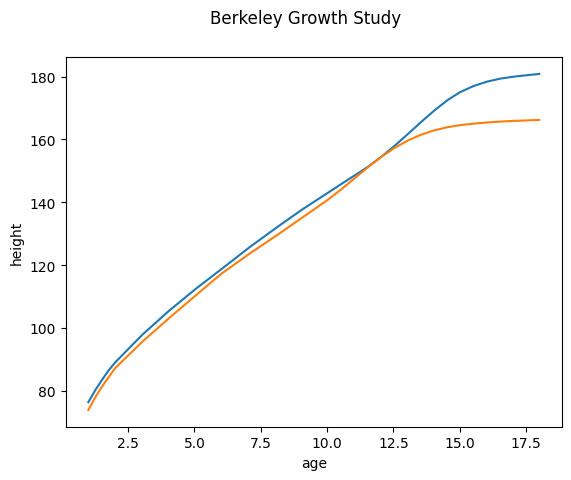

In [1]:
import skfda
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = skfda.datasets.fetch_growth(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = skfda.ml.classification.NearestCentroid()
classifier.fit(X_train, y_train)
classifier.centroids_.plot()
plt.show()

### Transformers

:term:`Transformers <sklearn:transformers>` are estimators which can convert
data to a new form. Examples of them are preprocessing methods, such as
smoothing, registration and dimensionality reduction methods. They always
implement ``fit_transform`` for fitting and transforming the data in one
step. The transformers may be :term:`sklearn:inductive`, which means that
can transform new data using the learned parameters. In that case they
implement the ``transform`` method to transform new data. If the
transformation is reversible, they usually also implement
``ìnverse_transform``.



As an example consider the smoothing method
:class:`skfda.preprocessing.smoothing.NadarayaWatsonHatMatrix`. Smoothing
methods attempt to remove noise from the data leveraging its continuous
nature.
As these methods discard information of the original data they usually are
not reversible.



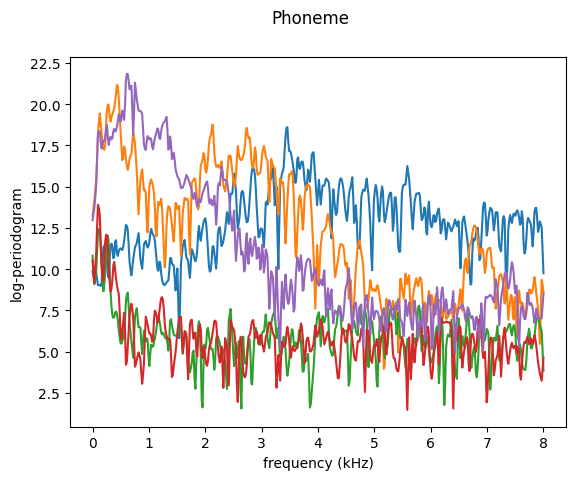

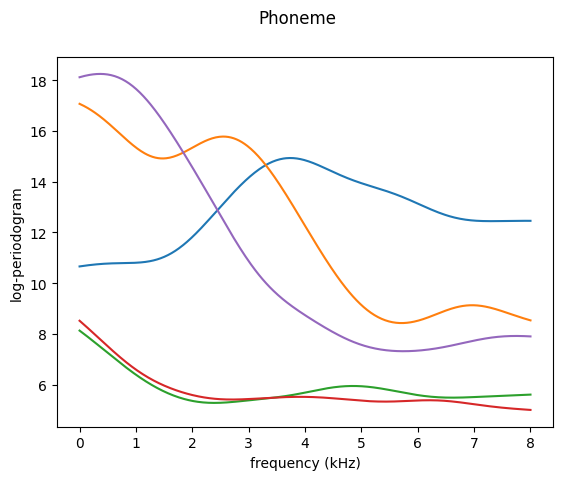

In [2]:
import skfda.preprocessing.smoothing as ks
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
X, y = skfda.datasets.fetch_phoneme(return_X_y=True)

# Keep the first 5 functions
X = X[:5]

X.plot()

smoother = ks.KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix())
X_smooth = smoother.fit_transform(X)

X_smooth.plot()
plt.show()

### Predictors (classifiers, regressors, clusterers...)

:term:`Predictors <sklearn:predictor>` in scikit-learn are estimators that
can assign a certain target to a particular observation. This includes
supervised methods such as classifiers (for which the target will be a class
label), or regressors (for which the target is a real value, a vector, or,
in functional data analysis, even a function!) and also unsupervised methods
such as clusterers or outlying detector methods.

Predictors should implement the ``fit_predict`` method for fitting the
estimators and predicting the targets in one step and/or the ``predict``
method for predicting the targets of possibly non previously observed data.
Usually :term:`sklearn:transductive` estimators implement only the former
one, while :term:`sklearn:inductive` estimators implement the latter one (or
both).

Predictors can have additional non-mandatory methods, such as
``predict-proba`` for obtaining the probability of a particular prediction
or ``score`` for evaluating the results of the prediction.



As an example, we can look at the :class:`~skfda.ml.clustering.KMeans`
clustering method for functional data. This method will try to separate
the data into different clusters according to the distance between
observations.



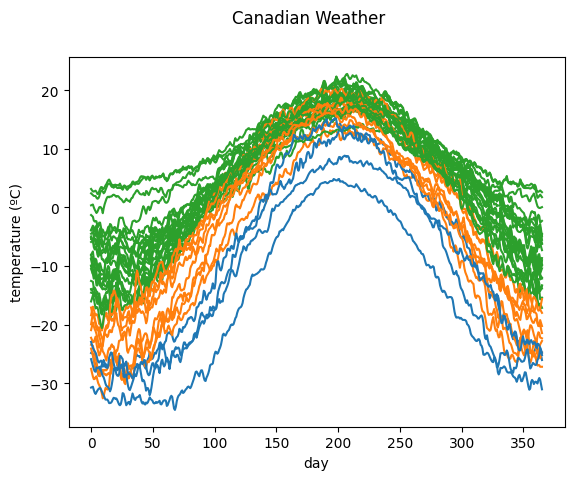

In [3]:
X, y = skfda.datasets.fetch_weather(return_X_y=True)

# Use only the first value (temperature)
X = X.coordinates[0]

clusterer = skfda.ml.clustering.KMeans(n_clusters=3)
y_pred = clusterer.fit_predict(X)

X.plot(group=y_pred)
plt.show()

### Metaestimators

In scikit-learn jargon, a :term:`sklearn:metaestimator` is an estimator
that takes other estimators as parameters. There are several reasons for
doing that, which will be explained now.



#### Composition metaestimators

It is very common in machine learning to apply one or more preprocessing
steps one after the other, before applying a final predictor. For this
purpose scikit-learn offers the :class:`~sklearn.pipeline.Pipeline`, which
join the steps together and uses the same estimator API for performing all
steps in order (this is usually referred as the composite pattern in
software engineering). The :class:`~sklearn.pipeline.Pipeline` estimator
can be used with the functional data estimators available in scikit-fda.
Moreover, as transformers such as dimensionality reduction methods can
convert functional data to multivariate data usable by scikit-learn methods
it is possible to mix methods from scikit-fda and scikit-learn in the same
pipeline.

<div class="alert alert-danger"><h4>Warning</h4><p>In addition, scikit-learn offers estimators that can join several
    transformations as new features of the same dataset (
    :class:`~sklearn.pipeline.FeatureUnion`) or that can apply different
    transformers to different columns of the data
    (:class:`~sklearn.compose.ColumnTransformer`). These transformers
    are not yet usable with functional data.</p></div>



As an example, we can construct a pipeline that registers the data using
shift registation, then applies a variable selection method to
transform each observation to a 3D vector and then uses a SVM classifier
to classify the data.



In [4]:
from skfda.preprocessing.dim_reduction import variable_selection as vs
from skfda.preprocessing.registration import LeastSquaresShiftRegistration
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

X, y = skfda.datasets.fetch_growth(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipeline = Pipeline([
    ("registration", LeastSquaresShiftRegistration()),
    ("dim_reduction", vs.RKHSVariableSelection(n_features_to_select=3)),
    ("classifier", SVC()),
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

1.0

#### Hyperparameter optimizers

Some of the parameters used for the creation of an estimator need to be
tuned to each particular dataset in order to improve the prediction accuracy
and generalization. There are several techniques to do that already
available in scikit-learn, such as grid search cross-validation
(:class:`~sklearn.model_selection.GridSearchCV`) or randomized search
(:class:`~sklearn.model_selection.RandomizedSearchCV`). As these
hyperparameter optimizers only need to split the data and call ``score`` in
the predictor, they can be directly used with the methods in scikit-fda.

<div class="alert alert-info"><h4>Note</h4><p>In addition one could use any optimizer that understand the scikit-learn
    API such as those in [scikit-optimize](https://scikit-optimize.github.io).</p></div>



As an example, we will use :class:`~sklearn.model_selection.GridSearchCV`
to select the number of neighbors used in a
:class:`~skfda.ml.classification.KNeighborsClassifier`.



In [ ]:
from sklearn.model_selection import GridSearchCV

X, y = skfda.datasets.fetch_growth(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = skfda.ml.classification.KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid={"n_neighbors": range(1, 10, 2)},
)

grid_search.fit(X_train, y_train)
n_neighbors = grid_search.best_estimator_.n_neighbors
score = grid_search.score(X_test, y_test)

print(n_neighbors, score)

#### Ensemble methods

The ensemble methods :class:`~sklearn.ensemble.VotingClassifier` and
:class:`~sklearn.ensemble.VotingRegressor` in scikit-learn use several
different estimators in order to predict the targets. As this is done
by evaluating the passed estimators as black boxes, these predictors can
also be combined with scikit-fda predictors.

<div class="alert alert-danger"><h4>Warning</h4><p>Other ensemble methods, such as
    :class:`~sklearn.ensemble.BaggingClassifier` or
    :class:`~sklearn.ensemble.AdaBoostClassifier` cannot yet
    be used with functional data unless it has been
    transformed to a multivariate dataset.</p></div>



As an example we will use a voting classifier to classify data using as
classifiers a knn-classifier, a nearest centroid classifier and a
maximum depth classifier.



In [ ]:
from sklearn.ensemble import VotingClassifier

X, y = skfda.datasets.fetch_growth(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

knn = skfda.ml.classification.KNeighborsClassifier()
nearest_centroid = skfda.ml.classification.NearestCentroid()
mdc = skfda.ml.classification.MaximumDepthClassifier()

voting = VotingClassifier([
    ("knn", knn),
    ("nearest_centroid", nearest_centroid),
    ("mdc", mdc),
])

voting.fit(X_train, y_train)
voting.score(X_test, y_test)

#### Multiclass and multioutput classification utilities

The scikit-learn library also offers additional utilities that can convert
a binary classifier into a multiclass classifier (such as
:class:`~sklearn.multiclass.OneVsRestClassifier`) or to extend a single
output classifier or regressor to accept also multioutput (vector-valued)
targets.



In this example we want to use as a classifier the combination of a
dimensionality reduction method (
:class:`~skfda.preprocessing.dim_reduction.variable_selection.RKHSVariableSelection`)
and a SVM classifier (:class:`~sklearn.svm.SVC`). As that particular
dimensionality reduction method is only suitable for binary data, we use
:class:`~sklearn.multiclass.OneVsRestClassifier` to classify in a
multiclass dataset.



In [ ]:
from sklearn.multiclass import OneVsRestClassifier

X, y = skfda.datasets.fetch_phoneme(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipeline = Pipeline([
    ("dim_reduction", vs.RKHSVariableSelection(n_features_to_select=3)),
    ("classifier", SVC()),
])

multiclass = OneVsRestClassifier(pipeline)

multiclass.fit(X_train, y_train)
multiclass.score(X_test, y_test)

### Other scikit-learn utilities

In addition to the aforementioned objects, there are plenty of objects in
scikit-learn that can be applied directly to functional data. We have
already seen in the examples the function
:func:`~sklearn.model_selection.train_test_split`. Other objects and
functions such as :class:`~sklearn.model_selection.KFold` can be directly
applied to functional data in order to split it into folds. Scorers for
classification or regression, such as
:func:`~sklearn.metrics.accuracy_score` can be directly applied to
functional data problems.

Moreover, there are plenty of libraries that aim to extend scikit-learn in
several directions (take a look at the [list of related projects](https://scikit-learn.org/stable/related_projects.html)). You will
probably see that a lot of the functionality can be applied to scikit-fda,
as it uses the same API as scikit-learn.

